# 实验5 PyTorch CNN 实战

Author: 高鹏昺

Email: nbgao@126.com

## Import

In [32]:
import torch
from torch import nn, optim
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torchvision as tv
from torchstat import stat
from torchvision import datasets, transforms
from torchvision.transforms import ToPILImage
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

import time
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
# Hyperparameters
batch_size = 64
learning_rate = 1e-2
num_epoches = 20

In [3]:
data_tf = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize([0.5],[0.5])]
)

In [4]:
train_dataset = datasets.MNIST(root='.', train=True, transform=data_tf, download=False)
print(train_dataset)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

Dataset MNIST
    Number of datapoints: 60000
    Root location: .
    Split: Train


In [5]:
test_dataset = datasets.MNIST(root='./', train=False, transform=data_tf, download=False)
print(test_dataset)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

Dataset MNIST
    Number of datapoints: 10000
    Root location: ./
    Split: Test


In [6]:
classes = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

In [7]:
(data, label) = train_dataset[100]
print(data.shape)
print(label)

torch.Size([1, 28, 28])
5


In [8]:
show = ToPILImage()

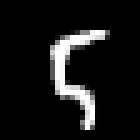

In [9]:
img = ((data+1)/2)
show(img).resize((140,140))

2 2 3 7 1 2 0 2 4 0 1 5 9 5 0 1 2 8 6 1 4 8 7 0 4 1 9 0 3 5 2 2 5 5 1 5 7 0 9 7 0 4 6 6 7 1 8 9 5 2 9 4 9 5 1 1 2 5 8 2 2 9 8 3


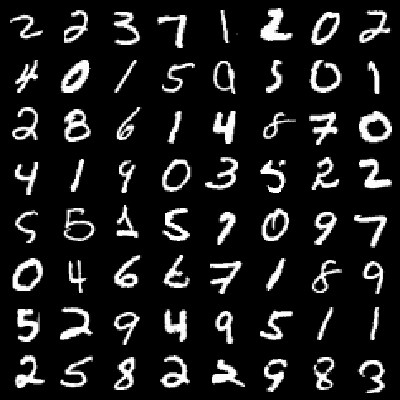

In [10]:
data_iter = iter(train_loader)
images, labels = data_iter.next()
print(' '.join('%s'%classes[labels[j]] for j in range(64)))
show(tv.utils.make_grid((images+1)/2)).resize((400,400))

### GPU

In [44]:
if torch.cuda.is_available():
    print('GPU num:', torch.cuda.device_count())
    print('GPU id:', torch.cuda.current_device())

GPU num: 1
GPU id: 0


## LeNet

In [42]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5, padding=2)
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.pool2 = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(16*5*5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
    def forward(self, x):
        # x: (64, 1, 28, 28)
        x = self.conv1(x)  # (64, 6, 28, 28)
        x = F.relu(x)
        x = self.pool1(x)
        
        x = self.conv2(x)  # (64, 16, 10, 10)
        x = F.relu(x)
        x = self.pool2(x)
        
        x = x.view(x.size()[0], -1)  # (64, 256)
        x = self.fc1(x)  # (64, 120)
        x = F.relu(x)
        
        x = self.fc2(x)  # (64, 84)
        x = F.relu(x)
        
        x = self.fc3(x)  # (64, 10)
        
        return F.log_softmax(x)

### LeNet Parameters

In [43]:
cnn = LeNet()
stat(cnn, (1, 28, 28))

      module name  input shape output shape   params memory(MB)       MAdd      Flops  MemRead(B)  MemWrite(B) duration[%]  MemR+W(B)
0           conv1    1  28  28    6  28  28    156.0       0.02  235,200.0  122,304.0      3760.0      18816.0      98.52%    22576.0
1           pool1    6  28  28    6  14  14      0.0       0.00    3,528.0    4,704.0     18816.0       4704.0       0.21%    23520.0
2           conv2    6  14  14   16  10  10   2416.0       0.01  480,000.0  241,600.0     14368.0       6400.0       0.40%    20768.0
3           pool2   16  10  10   16   5   5      0.0       0.00    1,200.0    1,600.0      6400.0       1600.0       0.20%     8000.0
4             fc1          400          120  48120.0       0.00   95,880.0   48,000.0    194080.0        480.0       0.30%   194560.0
5             fc2          120           84  10164.0       0.00   20,076.0   10,080.0     41136.0        336.0       0.18%    41472.0
6             fc3           84           10    850.0       0.0

In [17]:
# 选择CNN模型
cnn = LeNet()
if torch.cuda.is_available():
    cnn = cnn.cuda()
    print('[LeNet]: Use GPU')
else:
    print('[LeNet]: Use CPU')
print(cnn)

# 优化器参数
optimizer = optim.Adam(cnn.parameters(), lr=0.001, betas=(0.9, 0.99))
print(optimizer)
# 损失函数: 交叉熵损失函数(CE)
criterion = nn.CrossEntropyLoss(size_average=False)
print(criterion)

# 训练CNN模型
def train(epoch):
    for batch_idx, (data, label) in enumerate(train_loader):
        if torch.cuda.is_available():  # 使用GPU
            data, label = Variable(data, volatile=True).cuda(), Variable(label, volatile=True).cuda()
        # 梯度清零
        optimizer.zero_grad()
        # 模型预测结果
        predict = cnn(data)
        # 计算损失函数
        loss = criterion(predict, label)
        # 误差反向传播
        loss.backward()
        # 更新网络参数
        optimizer.step()
        # 输出训练阶段loss信息
        if batch_idx % 200 == 0:
            print('Train Epoch: {} [{:05d}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data.item()))

# 测试CNN模型
def test():
    test_loss = 0
    correct = 0
    for data, label in test_loader:
        if torch.cuda.is_available():  # 使用GPU
            data, label = Variable(data, volatile=True).cuda(), Variable(label, volatile=True).cuda()
        # 模型预测结果
        predict = cnn(data)
        # 计算batch损失和
        test_loss += criterion(predict, label).data.item()
        # 预测label
        pred = predict.data.max(1, keepdim=True)[1]
        # 预测正确数
        correct += pred.eq(label.data.view_as(pred)).sum()

    test_loss /= len(test_loader.dataset)
    # 输出测试阶段loss信息
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        correct.item()*100.0 / len(test_loader.dataset)))

[LeNet]: Use GPU
LeNet(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.99)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0
)
CrossEntropyLoss()


In [18]:
time_start = time.time()
for epoch in range(1, 10):
    # 每轮训练完测试
    train(epoch)
    test()

time_end = time.time()
print('Total Time: {:.1f}s.'.format(time_end-time_start))

Train Epoch: 1 [00000/60000 (0%)]	Loss: 146.794098
Train Epoch: 1 [12800/60000 (21%)]	Loss: 14.432417
Train Epoch: 1 [25600/60000 (43%)]	Loss: 7.218143
Train Epoch: 1 [38400/60000 (64%)]	Loss: 10.260456
Train Epoch: 1 [51200/60000 (85%)]	Loss: 2.189792

Test set: Average loss: 0.0797, Accuracy: 9741/10000 (97.41%)

Train Epoch: 2 [00000/60000 (0%)]	Loss: 7.897799
Train Epoch: 2 [12800/60000 (21%)]	Loss: 5.142151
Train Epoch: 2 [25600/60000 (43%)]	Loss: 2.044629
Train Epoch: 2 [38400/60000 (64%)]	Loss: 1.556409
Train Epoch: 2 [51200/60000 (85%)]	Loss: 2.076062

Test set: Average loss: 0.0417, Accuracy: 9867/10000 (98.67%)

Train Epoch: 3 [00000/60000 (0%)]	Loss: 0.760073
Train Epoch: 3 [12800/60000 (21%)]	Loss: 4.724016
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.370425
Train Epoch: 3 [38400/60000 (64%)]	Loss: 0.162365
Train Epoch: 3 [51200/60000 (85%)]	Loss: 13.794787

Test set: Average loss: 0.0405, Accuracy: 9866/10000 (98.66%)

Train Epoch: 4 [00000/60000 (0%)]	Loss: 1.039356
Train E

## AlexNet

In [13]:
batch_size = 100
learning_rate = 0.0001
momentum = 0.9
weight_decay = 0.0005
k = 2
n = 5
alpha = 1e-4
beta = 0.75

In [14]:
train_dataset = datasets.MNIST(root='./', train=True, transform=data_tf, download=False)
print(train_dataset)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./
    Split: Train


In [15]:
test_dataset = datasets.MNIST(root='./', train=False, transform=data_tf, download=False)
print(test_dataset)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

Dataset MNIST
    Number of datapoints: 10000
    Root location: ./
    Split: Test


In [68]:
time_start = time.time()
for epoch in range(1, 10):
    # 每轮训练完测试
    train(epoch)
    test()

time_end = time.time()
print('Total Time: {:.1f}s.'.format(time_end-time_start))

Train Epoch: 1 [00000/60000 (0%)]	Loss: 229.927429
Train Epoch: 1 [20000/60000 (33%)]	Loss: 130.008499
Train Epoch: 1 [40000/60000 (67%)]	Loss: 22.986048

Test set: Average loss: 0.0663, Accuracy: 9778/10000 (97.78%)

Train Epoch: 2 [00000/60000 (0%)]	Loss: 5.717216
Train Epoch: 2 [20000/60000 (33%)]	Loss: 0.849236
Train Epoch: 2 [40000/60000 (67%)]	Loss: 9.005154

Test set: Average loss: 0.0523, Accuracy: 9828/10000 (98.28%)

Train Epoch: 3 [00000/60000 (0%)]	Loss: 6.614645
Train Epoch: 3 [20000/60000 (33%)]	Loss: 1.233495
Train Epoch: 3 [40000/60000 (67%)]	Loss: 0.798077

Test set: Average loss: 0.0335, Accuracy: 9882/10000 (98.82%)

Train Epoch: 4 [00000/60000 (0%)]	Loss: 2.101755
Train Epoch: 4 [20000/60000 (33%)]	Loss: 3.027740
Train Epoch: 4 [40000/60000 (67%)]	Loss: 2.509169

Test set: Average loss: 0.0296, Accuracy: 9894/10000 (98.94%)

Train Epoch: 5 [00000/60000 (0%)]	Loss: 2.064038
Train Epoch: 5 [20000/60000 (33%)]	Loss: 4.181707
Train Epoch: 5 [40000/60000 (67%)]	Loss: 0.5

In [36]:
class AlexNet(nn.Module):
    def __init__(self):
        super(AlexNet,self).__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
#             nn.LocalResponseNorm(n, alpha=alpha, beta=beta, k=k),
            nn.MaxPool2d(kernel_size=2, stride=2), 
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
#             nn.LocalResponseNorm(n, alpha=alpha, beta=beta, k=k),
            nn.MaxPool2d(kernel_size=2,stride=2),
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        ) 
        self.layer4 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        )
        self.layer5 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.layer6 = nn.Sequential(
            nn.Linear(256*3*3, 1024),
            nn.Dropout(),
            nn.ReLU(inplace=True)
        )
        self.layer7 = nn.Sequential(
            nn.Linear(1024, 512),
            nn.Dropout(),
            nn.ReLU(inplace=True)
        ) 
        self.layer8 = nn.Sequential(
            nn.Linear(512, 10)
        )

    def forward(self,x):
        x = self.layer5(self.layer4(self.layer3(self.layer2(self.layer1(x)))))
        x = x.view(-1, 256*3*3)
        x = self.layer8(self.layer7(self.layer6(x)))
        return x

### AlexNet Parameters

In [38]:
cnn = AlexNet()
stat(cnn, (1, 28, 28))

[MAdd]: Dropout is not supported!
[Flops]: Dropout is not supported!
[Memory]: Dropout is not supported!
[MAdd]: Dropout is not supported!
[Flops]: Dropout is not supported!
[Memory]: Dropout is not supported!
[MAdd]: Dropout is not supported!
[Flops]: Dropout is not supported!
[Memory]: Dropout is not supported!
[MAdd]: Dropout is not supported!
[Flops]: Dropout is not supported!
[Memory]: Dropout is not supported!
[MAdd]: Dropout is not supported!
[Flops]: Dropout is not supported!
[Memory]: Dropout is not supported!
[MAdd]: Dropout is not supported!
[Flops]: Dropout is not supported!
[Memory]: Dropout is not supported!
[MAdd]: Dropout is not supported!
[Flops]: Dropout is not supported!
[Memory]: Dropout is not supported!
[MAdd]: Dropout is not supported!
[Flops]: Dropout is not supported!
[Memory]: Dropout is not supported!
      module name  input shape output shape     params memory(MB)           MAdd         Flops  MemRead(B)  MemWrite(B) duration[%]   MemR+W(B)
0        layer1.

In [17]:
# 选择CNN模型
cnn = AlexNet()
if torch.cuda.is_available():
    cnn = cnn.cuda()
    print('[AlexNet]: Use GPU')
else:
    print('[AlexNet]: Use CPU')
print(cnn)


# 优化器参数
optimizer = optim.SGD(cnn.parameters(), lr=0.0001, momentum=momentum, weight_decay=weight_decay)
# optimizer = optim.Adam(cnn.parameters(), lr=0.001, betas=(0.9, 0.99))
print(optimizer)
# 损失函数: 交叉熵损失函数(CE)
criterion = nn.CrossEntropyLoss(size_average=False)
print(criterion)

# 训练CNN模型
def train(epoch):
    for batch_idx, (data, label) in enumerate(train_loader):
        if torch.cuda.is_available():  # 使用GPU
            data, label = Variable(data, volatile=True).cuda(), Variable(label, volatile=True).cuda()
        # 梯度清零
        optimizer.zero_grad()
        # 模型预测结果
        predict = cnn(data)
        # 计算损失函数
        loss = criterion(predict, label)
        # 误差反向传播
        loss.backward()
        # 更新网络参数
        optimizer.step()
        # 输出训练阶段loss信息
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{:05d}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data.item()))

# 测试CNN模型
def test():
    test_loss = 0
    correct = 0
    for data, label in test_loader:
        if torch.cuda.is_available():  # 使用GPU
            data, label = Variable(data, volatile=True).cuda(), Variable(label, volatile=True).cuda()
        # 模型预测结果
        predict = cnn(data)
        # 计算batch损失和
        test_loss += criterion(predict, label).data.item()
        # 预测label
        pred = predict.data.max(1, keepdim=True)[1]
        # 预测正确数
        correct += pred.eq(label.data.view_as(pred)).sum()

    test_loss /= len(test_loader.dataset)
    # 输出测试阶段loss信息
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        correct.item()*100.0 / len(test_loader.dataset)))

[AlexNet]: Use GPU
AlexNet(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (layer4): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (layer5): Sequential(
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer6): Sequential(
    (0): Linear(in_features=2304, out_features=1024, bias=True)
    (1): Dropout(p=0.5)
    (2): ReLU(inplac

In [83]:
time_start = time.time()
for epoch in range(1, 10):
    # 每轮训练完测试
    train(epoch)
    test()

time_end = time.time()
print('Total Time: {:.1f}s.'.format(time_end-time_start))

Train Epoch: 1 [00000/60000 (0%)]	Loss: 230.157242
Train Epoch: 1 [20000/60000 (33%)]	Loss: 220.307007
Train Epoch: 1 [40000/60000 (67%)]	Loss: 9.427719

Test set: Average loss: 0.1058, Accuracy: 9662/10000 (96.62%)

Train Epoch: 2 [00000/60000 (0%)]	Loss: 18.087711
Train Epoch: 2 [20000/60000 (33%)]	Loss: 5.371624
Train Epoch: 2 [40000/60000 (67%)]	Loss: 5.955410

Test set: Average loss: 0.0427, Accuracy: 9849/10000 (98.49%)

Train Epoch: 3 [00000/60000 (0%)]	Loss: 1.183239
Train Epoch: 3 [20000/60000 (33%)]	Loss: 6.469438
Train Epoch: 3 [40000/60000 (67%)]	Loss: 16.949844

Test set: Average loss: 0.0312, Accuracy: 9891/10000 (98.91%)

Train Epoch: 4 [00000/60000 (0%)]	Loss: 0.848212
Train Epoch: 4 [20000/60000 (33%)]	Loss: 6.409442
Train Epoch: 4 [40000/60000 (67%)]	Loss: 1.325053

Test set: Average loss: 0.0327, Accuracy: 9893/10000 (98.93%)

Train Epoch: 5 [00000/60000 (0%)]	Loss: 0.671915
Train Epoch: 5 [20000/60000 (33%)]	Loss: 7.048769
Train Epoch: 5 [40000/60000 (67%)]	Loss: 10

## VGG-16

In [40]:
batch_size = 256
learning_rate = 0.01
momentum = 0.9
weight_decay = 0.0005

In [39]:
class VGG(nn.Module):
    def __init__(self, num_classes):
        super(VGG, self).__init__()    # (N, 3, 224, 224)
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),    # (N, 64, 224, 224)
            nn.ReLU(True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),    # (N, 64, 224, 224)
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=2, stride=2),    # (N, 64, 112, 112)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),    # (N, 128, 112, 112)
            nn.ReLU(True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),    # (N, 128, 112, 112)
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=2, stride=2),    # (N, 128, 56, 56)
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),    # (N, 256, 56, 56)
            nn.ReLU(True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),    # (N, 256, 56, 56)
            nn.ReLU(True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),    # (N, 256, 56, 56)
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=2, stride=2),    # (N, 256, 28, 28)          
        )
        self.layer4 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, padding=1),    # (N, 512, 28, 28)
            nn.ReLU(True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),    # (N, 512, 28, 28)
            nn.ReLU(True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),    # (N, 512, 28, 28)
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=2, stride=2)        
        )
        self.layer5 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, padding=1),    # (N, 512, 14, 14)
            nn.ReLU(True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),    # (N, 512, 14, 14)
            nn.ReLU(True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),    # (N, 512, 14, 14)
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=2, stride=2)    # (N, 512, 7, 7)      
        )
        
        self.layer6 = nn.Sequential(
            nn.Linear(512*7*7, 4096),
            nn.ReLU(True),
            nn.Dropout()
        )
        self.layer7 = nn.Sequential(
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout()     
        )     
        self.layer8 = nn.Sequential(
            nn.Linear(4096, num_classes)
        )
    
    def forward(self, x):
        x = self.layer5(self.layer4(self.layer3(self.layer2(self.layer1(x)))))
        x = x.view(x.shape[0], -1)
        x = self.layer8(self.layer7(self.layer6(x)))
        return x

### VGG-16 Parameters

In [35]:
cnn = VGG(10)
stat(cnn, (3, 224, 224))

[MAdd]: Dropout is not supported!
[Flops]: Dropout is not supported!
[Memory]: Dropout is not supported!
[MAdd]: Dropout is not supported!
[Flops]: Dropout is not supported!
[Memory]: Dropout is not supported!
[MAdd]: Dropout is not supported!
[Flops]: Dropout is not supported!
[Memory]: Dropout is not supported!
[MAdd]: Dropout is not supported!
[Flops]: Dropout is not supported!
[Memory]: Dropout is not supported!
      module name  input shape output shape       params memory(MB)              MAdd             Flops   MemRead(B)  MemWrite(B) duration[%]    MemR+W(B)
0        layer1.0    3 224 224   64 224 224       1792.0      12.25     173,408,256.0      89,915,392.0     609280.0   12845056.0       1.60%   13454336.0
1        layer1.1   64 224 224   64 224 224          0.0      12.25       3,211,264.0       3,211,264.0   12845056.0   12845056.0       0.31%   25690112.0
2        layer1.2   64 224 224   64 224 224      36928.0      12.25   3,699,376,128.0   1,852,899,328.0   12992768.

In [25]:
# 选择CNN模型
cnn = VGG(10)
if torch.cuda.is_available():
    cnn = cnn.cuda()
    print('[VGGNet]: Use GPU')
else:
    print('[VGGNet]: Use CPU')
print(cnn)


# 优化器参数
optimizer = optim.SGD(cnn.parameters(), lr=0.0001, momentum=momentum, weight_decay=weight_decay)
# optimizer = optim.Adam(cnn.parameters(), lr=0.001, betas=(0.9, 0.99))
print(optimizer)
# 损失函数: 交叉熵损失函数(CE)
criterion = nn.CrossEntropyLoss(size_average=False)
print(criterion)

# 训练CNN模型
def train(epoch):
    for batch_idx, (data, label) in enumerate(train_loader):
        if torch.cuda.is_available():  # 使用GPU
            data, label = Variable(data, volatile=True).cuda(), Variable(label, volatile=True).cuda()
        # 梯度清零
        optimizer.zero_grad()
        # 模型预测结果
        predict = cnn(data)
        # 计算损失函数
        loss = criterion(predict, label)
        # 误差反向传播
        loss.backward()
        # 更新网络参数
        optimizer.step()
        # 输出训练阶段loss信息
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{:05d}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data.item()))

# 测试CNN模型
def test():
    test_loss = 0
    correct = 0
    for data, label in test_loader:
        if torch.cuda.is_available():  # 使用GPU
            data, label = Variable(data, volatile=True).cuda(), Variable(label, volatile=True).cuda()
        # 模型预测结果
        predict = cnn(data)
        # 计算batch损失和
        test_loss += criterion(predict, label).data.item()
        # 预测label
        pred = predict.data.max(1, keepdim=True)[1]
        # 预测正确数
        correct += pred.eq(label.data.view_as(pred)).sum()

    test_loss /= len(test_loader.dataset)
    # 输出测试阶段loss信息
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        correct.item()*100.0 / len(test_loader.dataset)))

[VGGNet]: Use GPU
VGG(
  (layer1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU(inplace)
    (6): MaxPool2d(kernel_size=2, s

In [ ]:
time_start = time.time()
for epoch in range(1, 10):
    # 每轮训练完测试
    train(epoch)
    test()

time_end = time.time()
print('Total Time: {:.1f}s.'.format(time_end-time_start))

## Result

CNN|time|Accuracy
:-:|:-:|:-:
LeNet-5|55s|99.21%
AlexNet|96.2s|99.31%
VGGNet| 
GoogLeNet| 
ResNet| 